In [2]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

In [2]:
iris = datasets.load_iris()

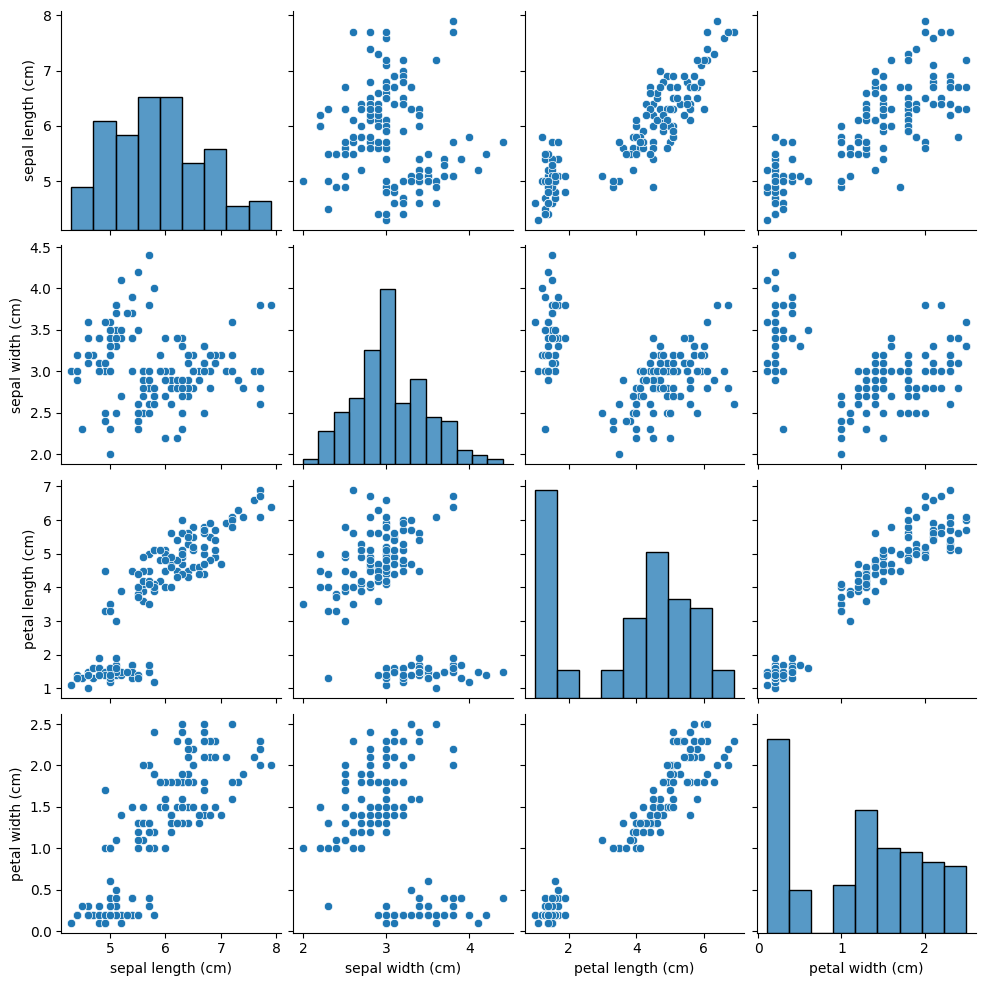

In [3]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [4]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

<font color="red">**Q1.** We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font>

In [6]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  return (x - mu) / sigma

mu = torch.mean(x_train, dim=0)
sigma = torch.std(x_train, dim=0)

x_train_norm = norm_set(x_train, mu, sigma)
x_test = norm_set(x_test, mu, sigma)

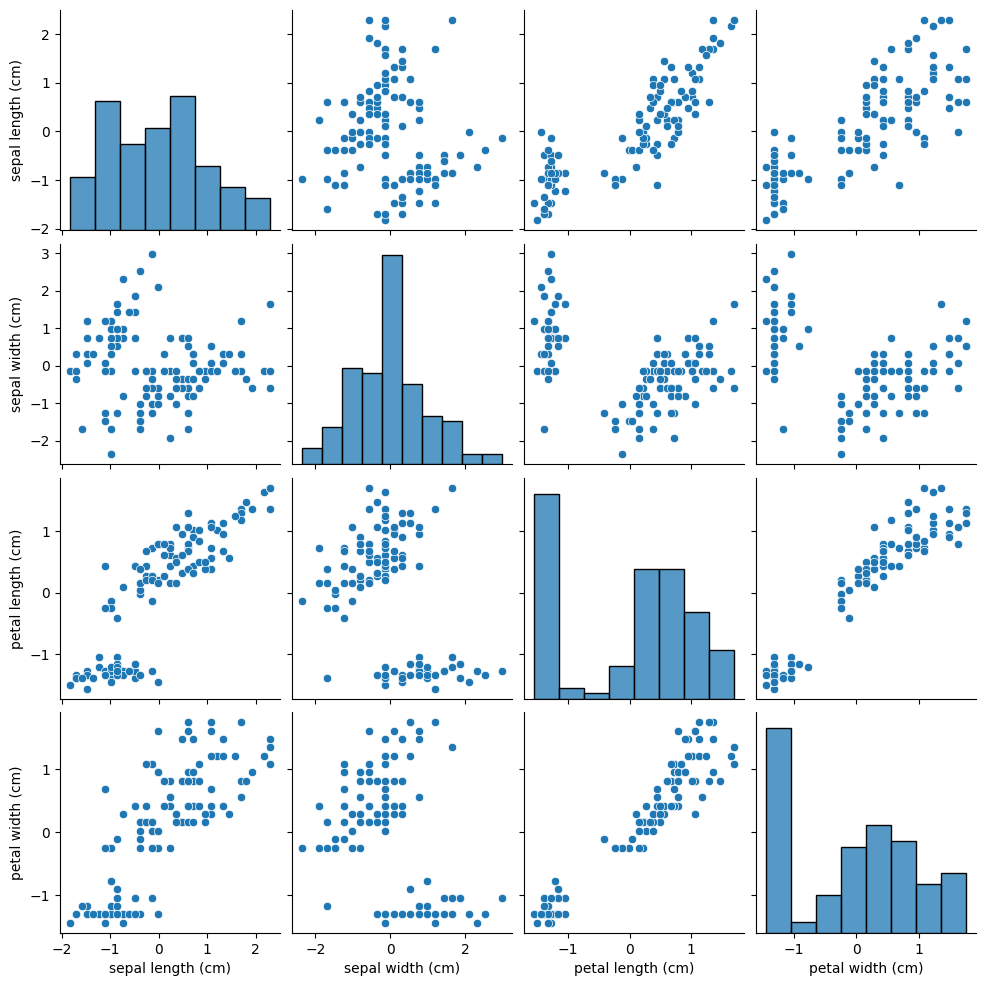

In [7]:
iris_norm_df = pd.DataFrame(x_train_norm.numpy(), columns=iris.feature_names)
sn.pairplot(iris_norm_df)

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

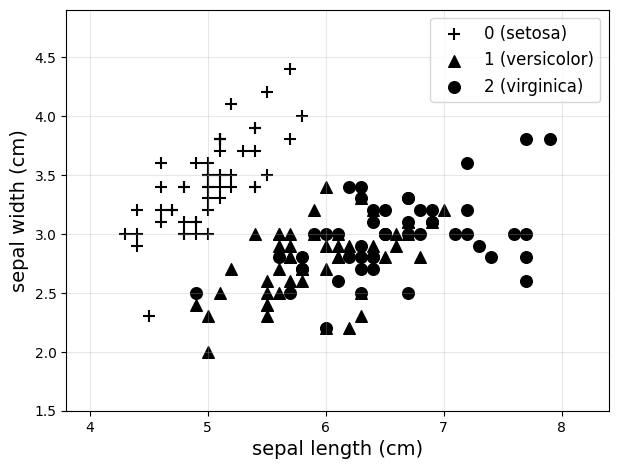

In [8]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '^', 'o']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [9]:
x_train = x_train_norm

In [10]:
train_set_1 = x_train[:, :2]
test_set_1 = x_test[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

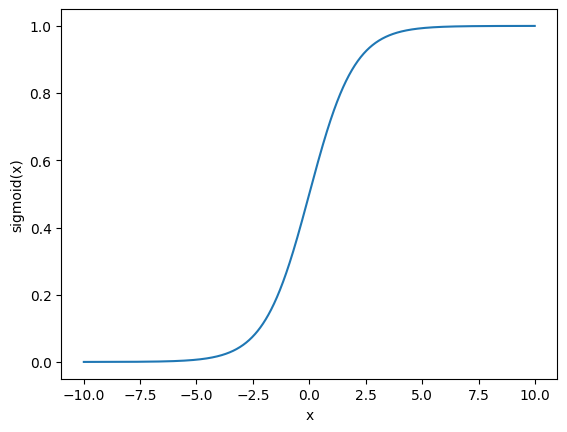

In [3]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-z))

x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [12]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    return torch.sigmoid(torch.matmul(x, self.weight.T))

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m}  \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**Q4.** Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

In [13]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  return torch.mean(-y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred))

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]

  gradient = torch.matmul(X.T, y_pred - y) / N
  weight = weight - lr * gradient.T

  model.weight = nn.Parameter(weight, requires_grad=False)

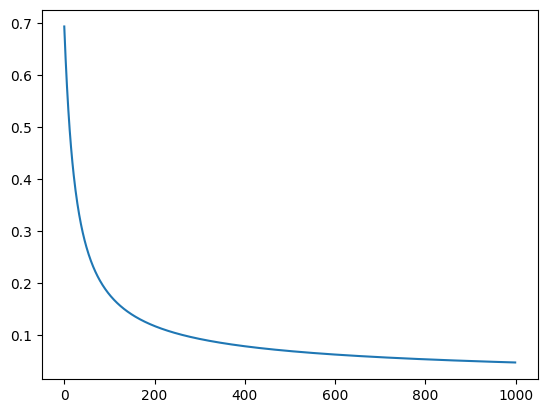

Minimum cost: 0.047883808612823486


In [14]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y, prediction, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 0.1 # select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

<font color="red"> **Q5.** Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font>

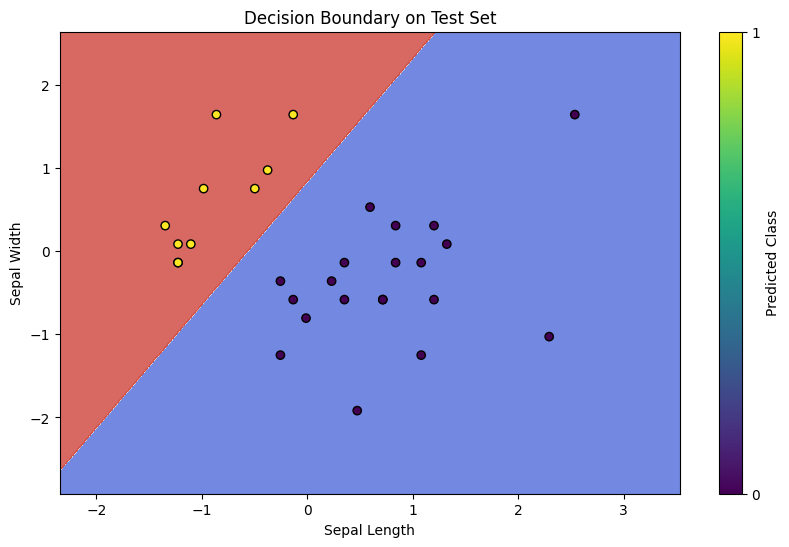

In [15]:
# Reference: https://scikit-learn.org/1.5/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn.inspection.DecisionBoundaryDisplay.from_estimator
import numpy as np

x_min, x_max = test_set_1[:, 0].min() - 1, test_set_1[:, 0].max() + 1
y_min, y_max = test_set_1[:, 1].min() - 1, test_set_1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)], dtype=torch.float32)
with torch.no_grad():
    z = model(grid_points)
z = (z > 0.5).float()
z = z.numpy().reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, z, alpha=0.8, cmap='coolwarm')
plt.scatter(test_set_1[:, 0], test_set_1[:, 1], c=setosa_test.numpy(), edgecolors='k', marker='o')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Decision Boundary on Test Set')
plt.colorbar(ticks=[0, 1], label='Predicted Class')
plt.show()

## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [16]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


In [17]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


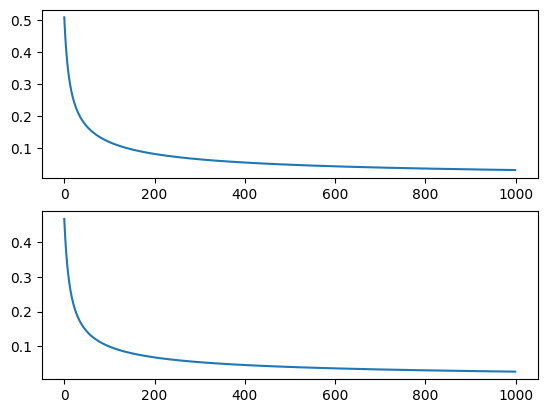

Minimum train cost: 0.032495297491550446
Minimum test cost: 0.02702244557440281


In [18]:
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)

How does the cost of the 4 attribute model compare to the previous one?

**Q6** Now train classifiers for the other two classes.[1 mark]

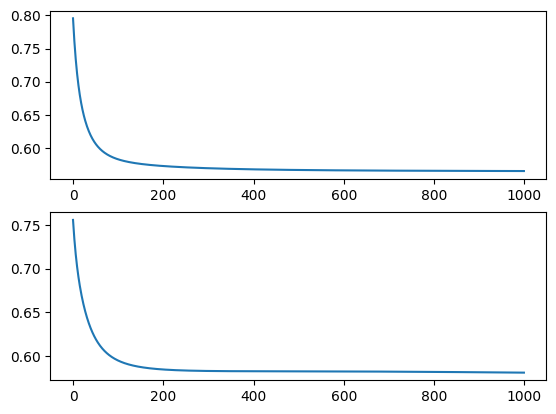

Minimum train cost: 0.5657476186752319
Minimum test cost: 0.5811511278152466


In [19]:
versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser = optim.SGD(versicolor_model.parameters(), alpha)
train(versicolor_model, x_train, versicolor_labels, x_test, versicolor_testy, optimiser, alpha)

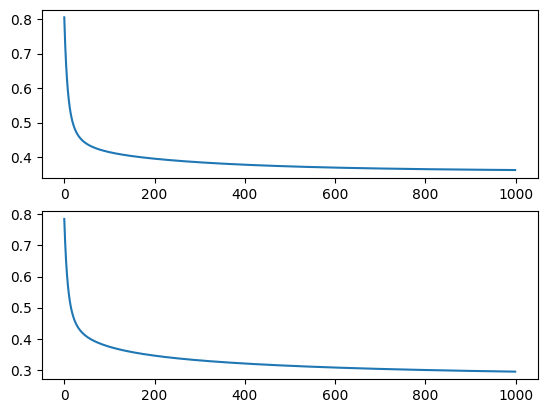

Minimum train cost: 0.36193257570266724
Minimum test cost: 0.29471829533576965


In [20]:
virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser = optim.SGD(virginica_model.parameters(), alpha)
train(virginica_model, x_train, virginica_labels, x_test, virginica_testy, optimiser, alpha)

<font color="red"> **Q7.** Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font>

In [31]:
setosa_preds = setosa_model(torch.FloatTensor(x_test)).detach().numpy()
versicolor_preds = versicolor_model(torch.FloatTensor(x_test)).detach().numpy()
virginica_preds = virginica_model(torch.FloatTensor(x_test)).detach().numpy()

predictions = np.hstack((setosa_preds, versicolor_preds, virginica_preds))

predicted_classes = np.argmax(predictions, axis=1)

class_names = ['Setosa', 'Versicolor', 'Virginica']
predicted_class_names = [class_names[i] for i in predicted_classes]

results_df = pd.DataFrame({
    'Setosa': setosa_preds.flatten(),
    'Versicolor': versicolor_preds.flatten(),
    'Virginica': virginica_preds.flatten(),
    'Predicted Class': predicted_class_names,
})

results_df

,Setosa,Versicolor,Virginica,Predicted Class
0,0.037149,0.763794,0.469811,Versicolor
1,0.999958,0.167037,0.111809,Setosa
2,0.000003,0.836757,0.946804,Virginica
3,0.038163,0.592865,0.705472,Virginica
4,0.007172,0.763175,0.538265,Versicolor
5,0.999631,0.293087,0.079935,Setosa
6,0.277473,0.534668,0.522587,Versicolor
7,0.001547,0.330015,0.966035,Virginica
8,0.000392,0.907160,0.384049,Versicolor
9,0.075422,0.730406,0.374203,Versicolor


<font color="red"> **Q8.** Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font>

In [22]:
setosa_logits = setosa_model(torch.FloatTensor(x_test))
versicolor_logits = versicolor_model(torch.FloatTensor(x_test))
virginica_logits = virginica_model(torch.FloatTensor(x_test))

logits = torch.cat((setosa_logits, versicolor_logits, virginica_logits), dim=1)

probabilities = F.softmax(logits, dim=1)

predicted_classes = torch.argmax(probabilities, dim=1).numpy()

ground_truth_classes = np.argmax(y_test, axis=1)

if isinstance(ground_truth_classes, torch.Tensor):
    ground_truth_classes = ground_truth_classes.numpy()

accuracy = np.mean(predicted_classes == ground_truth_classes)

print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

Accuracy on the test set: 90.00%


## 3. The XOR problem

<font color="red"> **Q9.** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? [2 marks] </font>

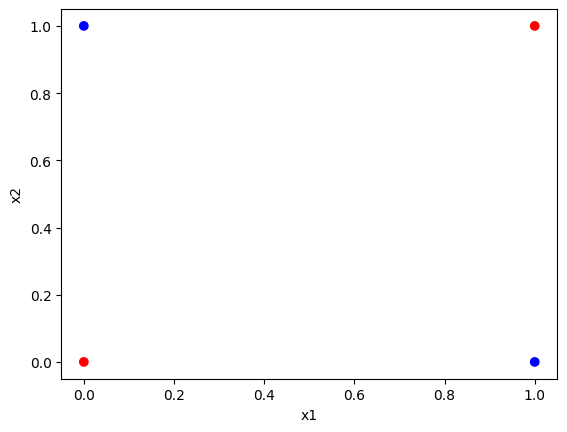

In [23]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()